# Multi Attributes Fractal Dimension

## Exploratory Data Analysis

Summarize about "SeisLab3.02" package. You can download from Mathworks [here](https://www.mathworks.com/matlabcentral/fileexchange/53109-seislab-3-02)

In [42]:
% Folder with 'SeisLab3.02' package
addpath(genpath('SeisLab3.02'))

% Folder with 'Segymat' package
addpath(genpath('Segymat'))

% Folder with data
addpath(genpath('Data'))

% Folder with Assets
addpath(genpath('Assets'))

In [2]:
tic
data = read_segy_file('Data/Inline 900-903/instantaneous_amplitude_IL_900-903.segy', ...
                     {'headers', {'iline_no', 189, 4, 'n/a', 'In-line number'}})
toc

Seismic data shifted since header "lag" is not identically zero.
Lag varies from 1300 to 1300

data = 

  struct with fields:

                      type: 'seismic'
                       tag: 'unspecified'
                      name: 'instantaneous_amplitude_IL_900-903 - shifted'
                      from: 'Data\Inline 900-903\instantaneous_amplitude_IL_900-903.segy'
               line_number: 1
               reel_number: 1
         traces_per_record: 1
                  cdp_fold: 1
                     first: 1300
                      last: 3300
                      step: 4
                     units: 'ms'
                    traces: [501x5132 double]
                      null: []
                   history: {2x4 cell}
               header_info: {13x3 cell}
                   headers: [13x5132 double]
    fp_format_of_segy_file: 'ibm'

Elapsed time is 0.750755 seconds.



In [3]:
format shortG
data.traces(1:5, 100)


ans =

       674.98
       639.51
       595.04
       484.41
       321.41




In [4]:
data.header_info


ans =

  13x3 cell array

    {'ds_seqno'  }    {'n/a'}    {'Trace sequence number within line'   }
    {'ffid'      }    {'n/a'}    {'Original Field record number'        }
    {'o_trace_no'}    {'n/a'}    {'Trace sequence number within orig...'}
    {'cdp'       }    {'n/a'}    {'CDP number'                          }
    {'seq_cdp'   }    {'n/a'}    {'Trace sequence number within CDP ...'}
    {'sou_x'     }    {'m'  }    {'X coordinate of source'              }
    {'sou_y'     }    {'m'  }    {'Y coordinate of source'              }
    {'cdp_x'     }    {'n/a'}    {'X-coordinate of CDP'                 }
    {'cdp_y'     }    {'n/a'}    {'Y-coordinate of CDP'                 }
    {'xline_no'  }    {'n/a'}    {'Cross-line number'                   }
    {'trc_type'  }    {'n/a'}    {'Trace type (1=live,2=dead,3=dummy...'}
    {'lag'       }    {'ms' }    {'Lag time between shot and recordi...'}
    {'iline_no'  }    {'n/a'}    {'In-line number'                      }




## Input data

Just in case you need to change the [format](https://www.mathworks.com/help/matlab/ref/format.html) to display data.

In [5]:
% format longG
format compact

In [6]:
% Definition of time window, above and below the horizon of interest.
TIME_ABOVE_HORIZON = 10;
TIME_BELOW_HORIZON = 50;

% Array of strings containing the names of the seismic attribute files.
files = {'Data/Inline 900-903/seismic_amplitude_IL_900-903.segy', ...
         'Data/Inline 900-903/instantaneous_amplitude_IL_900-903.segy', ...
         'Data/Inline 900-903/instantaneous_frecuency_IL_900-903.segy'};
         
% Array of strings containing the titles of the input seismic attributes.
titlesFiles = {'Seismic amplitude', 'Instantaneous amplitude', 'Instantaneous frequency'};

In [7]:
% Definition of the weights for each attributes. It must be the same quantity as the input attributes and their sum must be
% equal to 1. These are used to control the contribution of each seismic attribute in the calculation of Fractal Dimension.
ALPHA = [0.33, 0.33, 0.33];

% File to save the calculation of Fractal Dimension.
fileFractalDim = {'Data/EM_MER-U2_Fractal_Dimension.prn'};

% Number of traces to perform Quality Control (QC )of the calculations.
NUMTRACESQC = 5;

% Minimum and Maximum values of input seismic data. Extracted from Textual Header. [[min, max]; [min, max]; [min, max]]
MINMAX = [[-7469.42, 6192.14]; [0.0, 5228.60]; [0.0, 125.0]];

## Load data 

### Surface Data

In [8]:
% Opening of the time surface of interest. The format must be X - Y - Time. Otherwise, it would generate an error.
% X-Y are coordinates.
assy = fopen('Data/EM_MER-U2.prn');

switch assy
    case -1
        errordlg('The surface file is not in the current directory', 'Error!');
    otherwise
        try
            reg = fscanf(assy, '%10f');
            surfaceData = reshape(reg,3,[])';
        catch id
            errordlg('The file does not have the format X-Y-Time', 'Error!'); 
        end 
end

In [9]:
size(surfaceData)

ans =
      504175           3



In [10]:
% First 5 rows of surface data
format longG
surfaceData(1:5, :)

ans =
                    368425                   1018414                 2335.5974
                    368425                   1018564                 2332.6064
                    368425                   1018939                 2360.4221
                    368425                   1019014                 2350.2068
                    368425                   1019464                    2396.7



### Seismic data

In [11]:
% Number of attributes to use in the algorithm
nAttributes = size(files, 2);

In [12]:
% Raise error dialog if the sum of the weights is different from one, or they differ from the number of input attributes.

if (sum(ALPHA) < 0.99)
    errordlg('The sum of weights are not equal to 1', 'Error!'); 
    
elseif (nAttributes ~= size(ALPHA,2))
    errordlg('The number of weights is not equal to the input attributes.', 'Error!'); 
    
end

The following data must be the same for each seismic volume.
- dtSample: Sampling interval (microseconds).
- nSamples: Number of samples.
- nTraces: Number of traces.

In [13]:
% If there was selected only one seismic volume, no verification need it.

if nAttributes >= 2
    [dtSample, nSamples, nTraces] = checkSegyData(files);
else
    [segyHeader] = ReadSegyHeader(files{1});
    dtSample= segyHeader.dt/1000;
    nSamples= segyHeader.ns;
    nTraces = segyHeader.ntraces;
end

In [14]:
fprintf('Sampling interval: %d ms.   Number of samples: %d.   Number of traces: %d.\n', dtSample, nSamples, nTraces); 

Sampling interval: 4 ms.   Number of samples: 501.   Number of traces: 5132.



## Data preprocessing

### Time column

In [15]:
% Reade segy header
[segyHeader] = ReadSegyHeader(files{1});

% Read segy trace header
% 'SkipData': Read only the header values (Data will return empty)
[~ , segyTrace1Header] = ReadSegy(files{1}, 'traces', 1, 'SkipData', 1);

In [16]:
% From "segyHeader" read time column and sampling interval. Multiply and divide by 1000 to get miliseconds.
% From "segyTraceHeader" read "Delay Recording Time".
timeColumn = segyHeader.time*1000 - segyHeader.dt/1000 + segyTrace1Header.DelayRecordingTime;

In [17]:
% k1 and k2. Number of samples to extract seismic data for Fractal Dimension analysis.
% It depends on the time window previously chosen.
nTop = ceil(TIME_ABOVE_HORIZON/dtSample);
nBottom = ceil(TIME_BELOW_HORIZON/dtSample);

### Seismic data

It is very common seismic data with a constant number of seismic traces per Inline (so it is in these data). However, trace sequence line in segy file starts at 1 for each Inline, it does not follow a linear sequence. This sequence is calculated here, which will allow a much faster reading of data from a large file.

In [18]:
tic
% This function tackes too much execution time (3.2 seconds for read 4 Inlines).
% coordinatesSeismicTraces = traceNumbers(files{1}, nTraces);
toc

Elapsed time is 0.000151 seconds.



X-Y coordinates of all traces in the seismic volume. These coordinates will be the same in all input seismic volumes, because the sampling interval, the number of samples and the number of traces are the same. Also, they are divided by 100 to bring them to metric scale. 

In [19]:
tic
% Coordinates of seismic traces and trace numbers
coordinatesSeismicTraces = zeros(nTraces, 3);

% Read X and Y coordinates.
% <B = A.'> is equal to <B = transpose(A)>
coordinatesSeismicTraces(:,1) = ReadSegyTraceHeaderValue(files{1}, 'key', 'cdpX').';
coordinatesSeismicTraces(:,2) = ReadSegyTraceHeaderValue(files{1}, 'key', 'cdpY').';

% Divide each coordinate by 100 (metric scale)
coordinatesSeismicTraces = round(coordinatesSeismicTraces./100);

% Linear sequence of trace numbers.
coordinatesSeismicTraces(:, 3) = 1:nTraces;

toc

Elapsed time is 0.268627 seconds.



Select X-Y coordinates and the number of seismic traces where surface data was interpolated. 

In [20]:
selectedCoordinates = selectEqualCoord(nTraces, surfaceData, coordinatesSeismicTraces);

In [21]:
fprintf('Number of traces in seismic data is : %d.\nNumber of traces selected to Fractal Dimension Calculations: %d', ...
        size(coordinatesSeismicTraces, 1), size(selectedCoordinates, 1)); 

Number of traces in seismic data is : 5132.
Number of traces selected to Fractal Dimension Calculations: 1312


### Surface data

Select surface data with coordinates equal to seismic data.

In [22]:
selectedSurface = selectEqualCoord(nTraces, selectedCoordinates, surfaceData);

### Preallocating matrices

In [23]:
% Number of samples selected to Fractal dimension calculations.
nTracesSelected = size(selectedCoordinates, 1);

In [24]:
% This matrix will store the results of Fractal Dimension calculations.
results = zeros(nTracesSelected, 3);

% This vector will store the values of R2 in order to make a histogram.
allR2 = zeros(nTracesSelected, 1);

Definition of random numbers between 1 and the number of traces in seismic volumes. This will represent random traces, in order to perform Quality Control of Fractal Dimension calculations. In order to generate repeatable random numbers, we use:

``` python
rng(3, 'twister');
```

More information in this [link](https://www.mathworks.com/help/matlab/math/generate-random-numbers-that-are-repeatable.html).

In [25]:
rng(3, 'twister');
nTracesQc = round(rand(1, NUMTRACESQC) * nTraces);

In [26]:
nTracesQc

nTracesQc =
        2827        3634        1493        2622        4583



Description of the matrices for Quality control:
1. "*seismicTracesQc*": Seismic attributes traces.
2. "*paramsQc*": Number of traces, slope, Fractal Dimension and the coefficient of determination R2.
3. "*coordinatesQc*": Traces coordinates.
4. "*timeAnalysisQc*": Time interval analysis.
5. "*dividerLengthQc*": "Dividers" and "Length". Number of columns of both vectors is unknown, so pre-allocation is made with one column.

In [27]:
seismicTracesQc = zeros(nTop+nBottom+1, nAttributes, NUMTRACESQC);

paramsQc = zeros(NUMTRACESQC, 4);

coordinatesQc = zeros(NUMTRACESQC, 2);

timeAnalysisQc =  zeros(nTop+nBottom+1, NUMTRACESQC);

dividerLengthQc = zeros(2, 1, NUMTRACESQC);

## Multi-attributes Fractal Dimension Algorithm

In [28]:
% Close all open files
fclose('all');

% Initialize waitbar
wb = waitbar(0, 'Analyzing data');

% indexQc: index that indicates the trace number to QC.
indexQc = 1;

In [29]:
for iPoint = 1 : nTracesSelected
    % Plot waitbar
    waitbar(iPoint/nTracesSelected, wb)
    
    % Read trace number selected in seismic data.
    seismicData = zeros(nSamples, nAttributes);
    for jAttribute = 1 : nAttributes
        % Read Segy data of each input
        [Data, ~] = ReadSegy(files{jAttribute}, 'traces', selectedCoordinates(iPoint, 3));
        seismicData(:, jAttribute) = Data;
    end
    
    % Check if any of the seismic attributes data are empty. If this case, it will not calculate Fractal Dimension.
    isEmptyData= any(all(seismicData==0));

    % Continue calculations is seismic attributes data is not empty.
    if ~isEmptyData
        % Get time sample of surface data. "floor": Round towards -Inf.
        timeSample = floor(selectedSurface(iPoint,3));

        % Check if "timeSample" is a multiple of sampling interval of seismic data (4 miliseconds in this case).
        % Otherwise, take the next higher multiple.
        modulus = mod(timeSample, dtSample);
        while modulus~=0
            timeSample = timeSample - 1;
            modulus = mod(timeSample, dtSample);
        end

        % Find the position of "timeSample" in "timeColumn" vector.
        indexTimeSample = find(timeSample == timeColumn);

        % Select seismic attributes data between time window previously defined. This will be the data under analysis.
        analyzedData = zeros(nTop + nBottom + 1, nAttributes);

        for i = 1 : nAttributes
            analyzedData(:,i) = seismicData(indexTimeSample - nTop : indexTimeSample + nBottom, i);
        end

        % Normalization of data
        normalizedData = minMaxScaler(analyzedData, MINMAX);

        % Weighed normalized data
        normalizedData = normalizedData .* ALPHA;
        
        % Fractal Dimension calculation
        [dividers, length, slope, R2] = divplot2_EM(normalizedData);

        % Fractal Dimension of the curve in space N-Dimension.
        fractalDim = 1 + abs(slope);
        
        % Output. The order is X-Y-fractalDim.
        results(iPoint,:) = [selectedCoordinates(iPoint,1), selectedCoordinates(iPoint,2), fractalDim]; 

        % Save R2 values, in order to perform a histogram with the results.
        allR2(iPoint) = R2;

        % Check if the trace under analysis is the selected for quality control
        if ~isempty(intersect(nTracesQc, selectedCoordinates(iPoint, 3)))
            % Input Trace: Each 3D from the matrix Tr_Analysis_norm_QC has
            % data traces.
            seismicTracesQc(:, :, indexQc) = analyzedData;
            
            % Each column will correspond to the data of each trace:
            % Number of trace - slope - fractalDim - R2.
            paramsQc(indexQc, 1) = selectedCoordinates(iPoint, 3); 
            paramsQc(indexQc, 2) = slope; 
            paramsQc(indexQc, 3) = fractalDim; 
            paramsQc(indexQc, 4) = R2;
            
            % Coordinates X/Y - dividers/length
            coordinatesQc(indexQc, :) = surfaceData(iPoint, 1:2); 

            % Time column under analysis, according to time found in the
            % surface of interest.            
            initialTime = timeSample - (nTop * dtSample);            
            for i = 1 : (nTop+nBottom+1)
                timeAnalysisQc(i,indexQc) = initialTime + dtSample*(i-1);
            end % End for
            
            % "Dividers" size and total "length". The 3rd dimension
            % of the hyper matrix corresponds to each trace.
            dividerLengthQc(1, 1:size(dividers,2), indexQc) = dividers; 
            dividerLengthQc(2, 1:size(dividers,2), indexQc) = length; 

            indexQc = indexQc + 1;
        end % End if

    % Close all open files.
    fclose('all');
    
    end % End if

end % End for

% Close waitbar
close(wb)

## Results

In [30]:
% Remove zero rows (empty traces) from Fractal Dimension matrix.
results( ~any(results, 2), : ) = [];

% Fractal Dimension surface file.
dlmwrite(fileFractalDim{1}, results, 'delimiter',' ','precision','%15.5f')

% Close all open files
fclose('all');

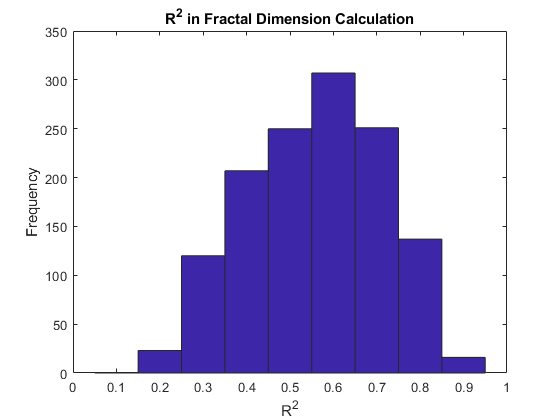

In [31]:
qualityControlHist(allR2)

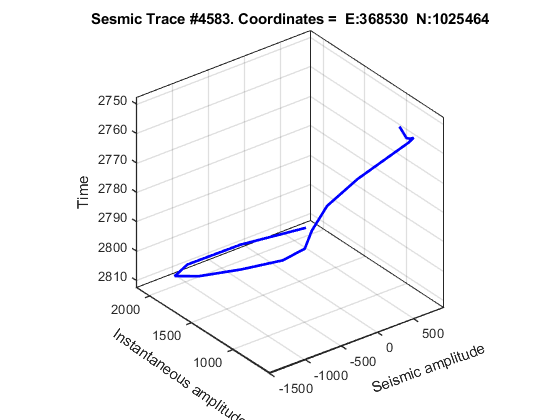

In [32]:
qualityControlTrace(seismicTracesQc, paramsQc, coordinatesQc, timeAnalysisQc, titlesFiles, 1)

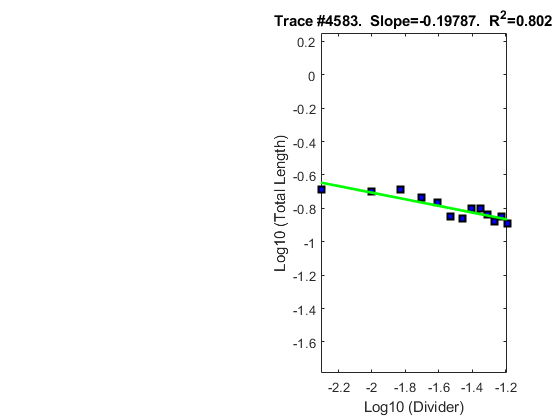

In [43]:
qualityControlDividerLength(seismicTracesQc, paramsQc, dividerLengthQc, 1)

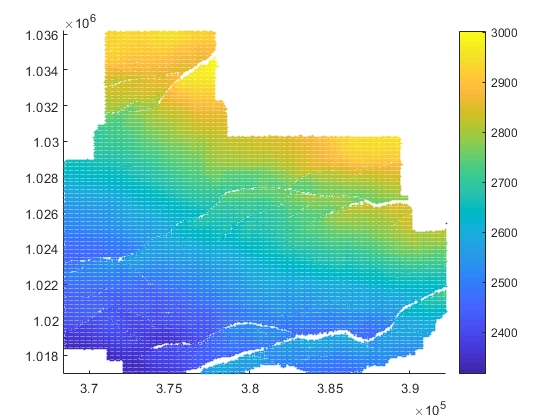

In [34]:
scatter(surfaceData(:, 1), surfaceData(:, 2), 1.0, surfaceData(:, 3));
xlim([min(surfaceData(:, 1)), max(surfaceData(:, 1))]);
ylim([min(surfaceData(:, 2)), max(surfaceData(:, 2))]);
colorbar